In [3]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.losses import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [22]:
np.random.seed(1)
stock = 'SPY'
data = pd.read_feather(f'C:/Users/PieterVerloop/Downloads/Papers DS/0000 DATA/stock-price-forecasting-dcgan-main/stock-price-forecasting-dcgan-main/data/XGBoost10/df_{stock}_XGBoost10.feather')
data['close']

0       136.000000
1       140.750000
2       144.468750
3       143.125000
4       143.812500
           ...    
5459    477.260010
5460    476.869995
5461    477.480011
5462    476.160004
5463    474.959991
Name: close, Length: 5464, dtype: float64

In [23]:
close_log = np.log(data['close'])
train_data, test_data = close_log[:int(len(close_log)*0.8)], close_log[int(len(close_log)*0.8):]

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-26104.292, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-26119.959, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-26122.552, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-26105.760, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-26133.030, Time=0.42 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-26136.387, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-26138.303, Time=0.60 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-26136.373, Time=0.57 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-26134.358, Time=0.88 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-26139.626, Time=0.55 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-26121.361, Time=0.35 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-26137.701, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-26137.716, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-26134.399, Time=0.43 sec
 ARIM

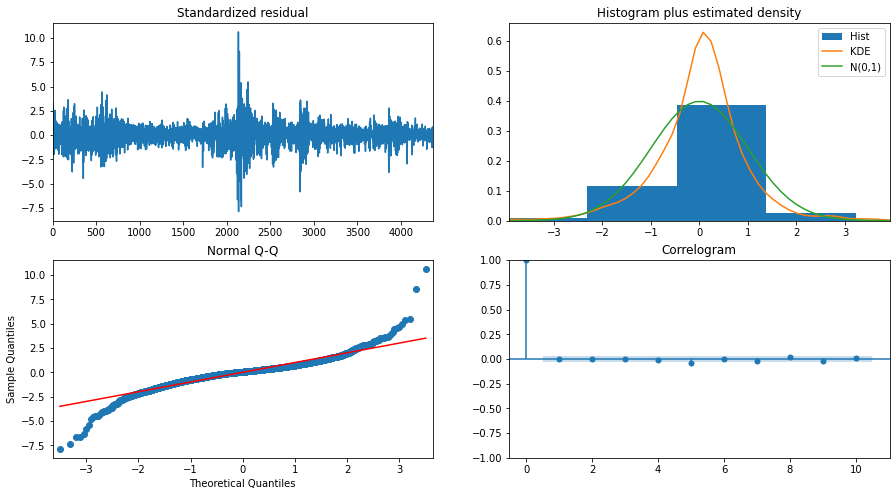

In [24]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      n_fits=25,
                      maxiter=10)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [25]:
model = ARIMA(train_data, order=model_autoARIMA.get_params().get("order"))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 4371
Model:                 ARIMA(2, 1, 0)   Log Likelihood               13072.813
Date:                Fri, 06 Jan 2023   AIC                         -26139.626
Time:                        11:26:38   BIC                         -26120.479
Sample:                             0   HQIC                        -26132.870
                               - 4371                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0692      0.009     -7.959      0.000      -0.086      -0.052
ar.L2         -0.0679      0.007    -10.284      0.000      -0.081      -0.055
sigma2         0.0001   1.43e-06    102.962      0.0

C:\Users\PieterVerloop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [26]:
# No rolling window
fc = fitted.forecast(len(test_data), alpha=0.05)
f = np.exp(fc)
f

4371    244.829951
4372    244.812306
4373    244.814888
4374    244.815909
4375    244.815663
           ...    
5459    244.815631
5460    244.815631
5461    244.815631
5462    244.815631
5463    244.815631
Name: predicted_mean, Length: 1093, dtype: float64

In [27]:
test_data_exp = np.exp(test_data)
RMSE = np.round(np.sqrt(mean_squared_error(f, test_data_exp)), 4)
print('RMSE: '+str(RMSE))
MAE = np.round(mean_absolute_error(f, test_data_exp), 4)
print('MAE: '+str(MAE))
MAPE = np.round(mean_absolute_percentage_error(f, test_data_exp), 4)
print('MAPE: '+str(MAPE))

RMSE: 100.7633
MAE: 78.0443
MAPE: 31.8788


In [28]:
# Rolling window day ahead
history = [x for x in train_data]
predictions = list()
test_arr = test_data.to_numpy()
# walk-forward validation
for t in range(len(test_data)):
	history = history[len(history)-5:len(history)]
	model = ARIMA(history, order=model_autoARIMA.get_params().get("order")) 
	model_fit = model.fit()
	output = model_fit.predict(start=1, end=1)
	predictions.append(output[0])
	obs = test_arr[t]
	history.append(obs)
# predictions

C:\Users\PieterVerloop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\PieterVerloop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\PieterVerloop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization faile

In [29]:
# Single step evaluation
pred_exp = np.exp(np.array(predictions).reshape(len(predictions)))
test_data_exp = np.exp(test_data)
RMSE = np.round(np.sqrt(mean_squared_error(pred_exp, test_data_exp)), 4)
print('RMSE: '+str(RMSE))
MAE = np.round(mean_absolute_error(pred_exp, test_data_exp), 4)
print('MAE: '+str(MAE))
MAPE = np.round(mean_absolute_percentage_error(pred_exp, test_data_exp), 4)
print('MAPE: '+str(MAPE))

RMSE: 7.7778
MAE: 5.3938
MAPE: 1.7175


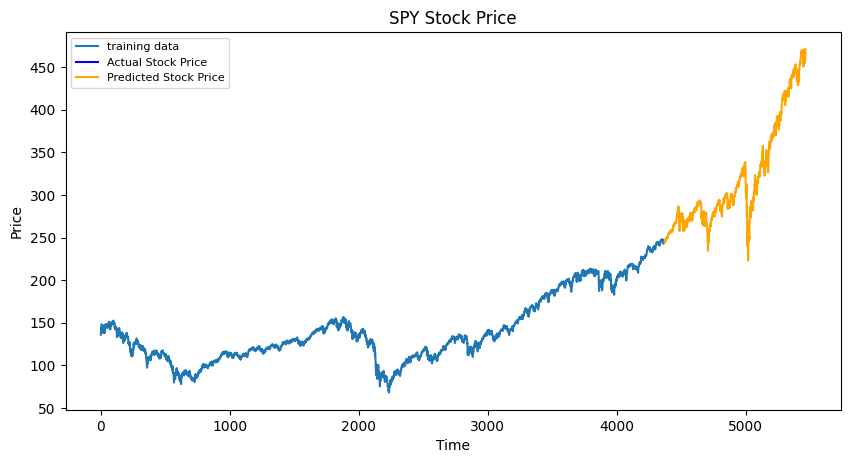

In [30]:
# Make as pandas series
fc_series = pd.Series(pred_exp, index=test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(data['close'][:len(train_data)], label='training data')
plt.plot(data['close'][len(train_data)], color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')

plt.title(f'{stock} Stock Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [33]:
# Rolling window 5 day ahead
history = [x for x in train_data]
predictions = list()
true_multi = list()
test_arr = test_data.to_numpy()
# walk-forward validation
for t in range(5, len(test_data), 5):
    history = history[len(history)-6:len(history)-1]
    model = ARIMA(history, order=model_autoARIMA.get_params().get("order"))
    model_fit = model.fit()
    output = model_fit.predict(start=1, end=5)
    predictions.append(list(output))
    true_multi.append(list(test_arr[t-5:t]))
    obs = list(test_arr[t-5:t])
    history.extend(obs)

C:\Users\PieterVerloop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\PieterVerloop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\PieterVerloop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\PieterVerl

In [34]:
# Multi step evaluation
preds = [item for sublist in predictions for item in sublist]
pred_exp = np.exp(preds)
trues = [item for sublist in true_multi for item in sublist]
test_data_exp = np.exp(trues)
RMSE = np.round(np.sqrt(mean_squared_error(pred_exp, test_data_exp)), 4)
print('RMSE: '+str(RMSE))
MAE = np.round(mean_absolute_error(pred_exp, test_data_exp), 4)
print('MAE: '+str(MAE))
MAPE = np.round(mean_absolute_percentage_error(pred_exp, test_data_exp), 4)
print('MAPE: '+str(MAPE))

RMSE: 8.5033
MAE: 5.905
MAPE: 1.8892
